# So you have some sequencing data, now what?
First, let's get some imports and ipython magic. Ideally, you see no errors here otherwise you're on your own for troubleshooting them as everything here is strictly required

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
from collections import Counter
import sequencing_analysis_library as SAL
from Bio import SeqIO
import numpy as np
from scipy import stats
import pandas as pd

/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Initially at least, we're going to assume your sequencing reads are in the form of FASTQ files with one FASTQ file containing all of the reads for a given sample and another FASTQ containing the reads for that sample that did not map to rRNAs (or whatever form of filtering you decided on). This is strictly for diagnostic purposes

In [3]:
sample_names = ['SQ-1', 'SQ-2', 'SQ-3', 'SQ-4', 'SQ-5', 'SQ-6', 'SQ-7', 'SQ-8', 'SQ-9', 'SQ-10', 'SQ-11', 'SQ-12']
# sample_names = ['SQ-7', 'SQ-8', 'SQ-9', 'SQ-10', 'SQ-11', 'SQ-12']
# sample_names = ['SQ-13', 'SQ-14', 'SQ-15', 'SQ-16', 'SQ-17', 'SQ-18']


generic_fq = '/Users/adamhockenberry/Projects/Neisseria/Data/SequencingData/Neisseria/FASTQ/XXXX_filtered.fq'
generic_no_rrna_fq = '/Users/adamhockenberry/Projects/Neisseria/Data/SequencingData/Neisseria/FASTQ/XXXX_no_rrnas.fastq'
organism = 'Neisseria'

# sample_names = ['PYE_rpf', 'PYE_RNA', 'M2G_rpf', 'M2G_RNA']
# generic_fq = '/Users/adamhockenberry/Projects/Neisseria/Data/SequencingData/Caulobacter/FASTQ/XXXX.fastq'
# generic_no_rrna_fq = '/Users/adamhockenberry/Projects/Neisseria/Data/SequencingData/Caulobacter/FASTQ/XXXX_no_rrnas.fastq'
# organism = 'Caulobacter'

# sample_names = ['exponential_RNA', 'exponential_rpf', 'biofilm_RNA', 'biofilm_rpf']
# generic_fq = '/Users/adamhockenberry/Projects/Neisseria/Data/SequencingData/Bacillus/FASTQ/XXXX.fastq'
# generic_no_rrna_fq = '/Users/adamhockenberry/Projects/Neisseria/Data/SequencingData/Bacillus/FASTQ/XXXX_no_rrnas.fastq'

total_reads_dict, rrna_reads_dict = SAL.analyze_rrna_percents(sample_names, generic_fq, generic_no_rrna_fq)

This is the start of our dataframe which will contain relevant statistics for each sample

In [4]:
df = pd.DataFrame(index=sample_names)
df['Total_reads'] = pd.Series([total_reads_dict[sample] for sample in df.index], index=df.index)
df['rRNA_reads'] = pd.Series([rrna_reads_dict[sample] for sample in df.index], index=df.index)
df

,Total_reads,rRNA_reads
SQ-1,37756955.0,918030.0
SQ-2,28527455.0,734790.0
SQ-3,24277417.0,594922.0
SQ-4,16994208.0,430037.0
SQ-5,31648404.0,783929.0
SQ-6,22534121.0,598598.0
SQ-7,22477141.0,16987058.0
SQ-8,28175316.0,4872794.0
SQ-9,30521932.0,21098656.0
SQ-10,27326481.0,20317702.0


# SAM files to wiggle files
Since you should have used bowtie or some relevant alignment program, this will take your relatively enormous .SAM file and make .WIG files for easier use. Along the way we'll also add in some diagnostics columns to our dataframe for safe keeping. Technically, after this you can delete the .SAM files since most all other work will likely be working directly with the .wig format.

This will also produce some histograms of gene lengths for the mapped and unmapped reads which may be useful.

In [20]:
generic_sam_file = '/Users/adamhockenberry/Projects/Neisseria/Data/SequencingData/Neisseria/SAM/XXXX_default.SAM'
organism = 'Neisseria'
genome_list = list(SeqIO.parse('../Data/Genomes/fa1090.gb', 'genbank'))

# generic_sam_file = '/Users/adamhockenberry/Projects/Neisseria/Data/SequencingData/Caulobacter/SAM/XXXX_best.SAM'
# organism = 'Caulobacter'
# genome_list = list(SeqIO.parse('../Data/Genomes/na1000.gb', 'genbank'))

length_restriction = (20, 100)
assignment='all'
total_dict = {}
for sample_name in sample_names:
    print(sample_name)
    mapped_len_dict = SAL.sam_to_wiggle(generic_sam_file.replace('XXXX', sample_name),\
                      organism, genome_list, length_restriction=length_restriction, assignment=assignment)

    SAL.length_histograms(sample_name + '_({}_{})_default'.format(length_restriction[0], length_restriction[1]),\
                                                           mapped_len_dict, organism)
    
    for key in mapped_len_dict.keys():
        mapped_len_dict[key] = len(mapped_len_dict[key])
        
    total_dict[sample_name] = mapped_len_dict

SQ-1
SQ-2
SQ-3
SQ-4
SQ-5
SQ-6


In [21]:
df['Unmapped_reads({},{})'.format(length_restriction[0], length_restriction[1])] = pd.Series([total_dict[sample]['Unmapped'] for sample in df.index], index=df.index)
df['Plus_strand_reads({},{})'.format(length_restriction[0], length_restriction[1])] = pd.Series([total_dict[sample]['Plus'] for sample in df.index], index=df.index)
df['Minus_strand_reads(non_rRNA)({},{})'.format(length_restriction[0], length_restriction[1])] = pd.Series([total_dict[sample]['Minus'] for sample in df.index], index=df.index)
df['Total_mapped(non_rRNA)({},{})'.format(length_restriction[0], length_restriction[1])] = pd.Series([total_dict[sample]['Plus'] + total_dict[sample]['Minus'] for sample in df.index], index=df.index)
df

,Total_reads,rRNA_reads,"Unmapped_reads(20,100)","Plus_strand_reads(20,100)","Minus_strand_reads(non_rRNA)(20,100)","Total_mapped(non_rRNA)(20,100)"
SQ-1,37756955,918030,1371361,16512522,18955042,35467564
SQ-2,28527455,734790,1585741,12793285,13413639,26206924
SQ-3,24277417,594922,1088803,10274923,12318769,22593692
SQ-4,16994208,430037,999463,7500238,8064470,15564708
SQ-5,31648404,783929,1205665,13481850,16176960,29658810
SQ-6,22534121,598598,1119866,10259029,10556628,20815657


# A few more wiggle files might be useful so let's make them quick since we have the data loaded

In [14]:
genome_file = '../Data/Genomes/fa1090.gb'
genome = list(SeqIO.parse(genome_file, 'genbank'))[0]

# samples_to_average = ['SQ-1', 'SQ-3', 'SQ-5']
# samples_to_average = ['SQ-2', 'SQ-4', 'SQ-6']
# samples_to_average = ['SQ-7', 'SQ-9', 'SQ-11']
samples_to_average = ['SQ-10', 'SQ-12']
generic_wig_f = '../Data/Neisseria/XXXX_best_20_100_all_normed_f.wig'
generic_wig_r = '../Data/Neisseria/XXXX_best_20_100_all_normed_r.wig'
output_file_f = '../Data/Neisseria/SQ-(10,12)_20_100_normed_f.wig'
output_file_r = '../Data/Neisseria/SQ-(10,12)_20_100_normed_r.wig'

meta_dict = {}
for sample_name in samples_to_average:
    fwd_wiggle = generic_wig_f.replace('XXXX', sample_name)
    rev_wiggle = generic_wig_r.replace('XXXX', sample_name)
    fwd_dicty, rev_dicty = SAL.read_single_wiggle(fwd_wiggle, rev_wiggle)
    meta_dict[sample_name] = fwd_dicty, rev_dicty
avg_dict_f = {}
avg_dict_r = {}
for i in range(len(genome.seq)):
    tempy_f = []
    tempy_r = []
    for sample_name in samples_to_average:
        try:
            tempy_f.append(meta_dict[sample_name][0][i])
        except KeyError:
            tempy_f.append(0)
        try:
            tempy_r.append(meta_dict[sample_name][1][i])
        except KeyError:
            tempy_r.append(0)
    avg_dict_f[i] = np.mean(tempy_f)
    avg_dict_r[i] = np.mean(tempy_r)

with open(output_file_f, 'w') as outfile:
    for pos in sorted(list(avg_dict_f.keys())):
        if avg_dict_f[pos] > 0:
            outfile.write('{}\t{}\n'.format(pos, avg_dict_f[pos]))
with open(output_file_r, 'w') as outfile:
    for pos in sorted(list(avg_dict_r.keys())):
        if avg_dict_r[pos] > 0:
            outfile.write('{}\t{}\n'.format(pos, avg_dict_r[pos]))

# That should about do it for our diagnostics so we can save that excel file and move on to looking at the reads that actually mapped

In [22]:
writer = pd.ExcelWriter('../Results/{}_default_20_100_all_output.xlsx'.format(organism))
df.to_excel(writer)
writer.save()

# From here on out, all we need are .wig files so you if you didn't have raw reads to work with but want to join the pipeline, now is your chance. 

# Metagene analysis

SQ-7 initially had 1884 genes
... it now has 1820 after coverage and length pruning
SQ-8 initially had 1884 genes
... it now has 1012 after coverage and length pruning
SQ-9 initially had 1884 genes
... it now has 1861 after coverage and length pruning
SQ-10 initially had 1884 genes
... it now has 1847 after coverage and length pruning
SQ-11 initially had 1884 genes
... it now has 1813 after coverage and length pruning
SQ-12 initially had 1884 genes
... it now has 1868 after coverage and length pruning


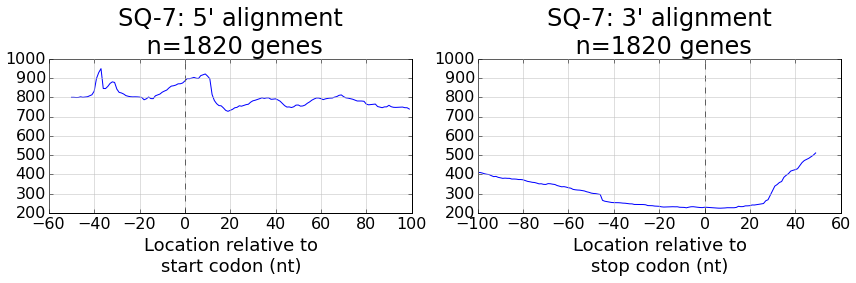

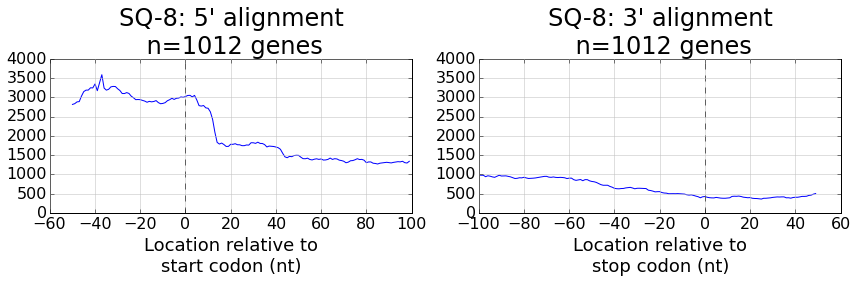

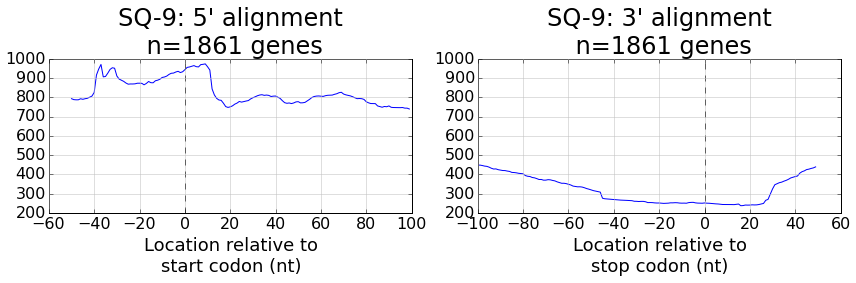

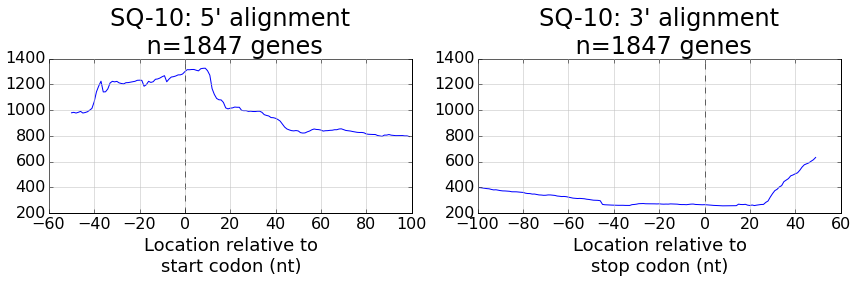

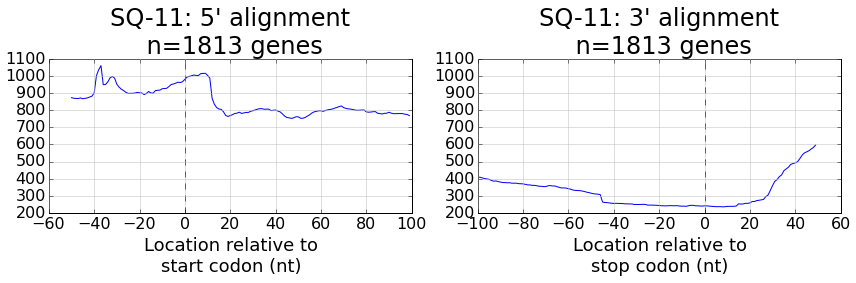

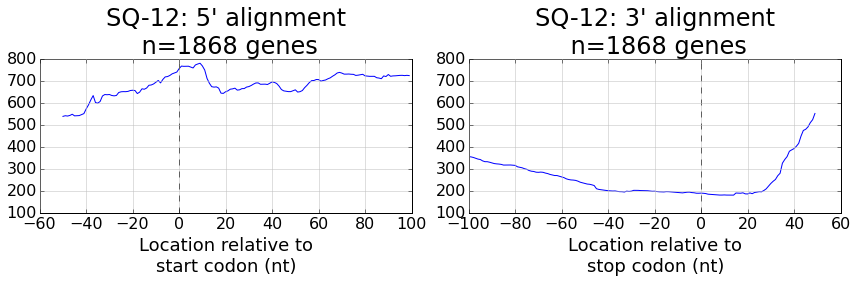

In [17]:
genome_file = '../Data/Genomes/fa1090.gb'
genome = list(SeqIO.parse(genome_file, 'genbank'))[0]
organism = 'Neisseria'
# sample_files = ['SQ-1', 'SQ-2', 'SQ-3', 'SQ-4', 'SQ-5', 'SQ-6']
sample_files = ['SQ-7', 'SQ-8', 'SQ-9', 'SQ-10', 'SQ-11', 'SQ-12']
generic_wig_f = '../Data/Neisseria/XXXX_best_20_100_all_normed_f.wig'
generic_wig_r = '../Data/Neisseria/XXXX_best_20_100_all_normed_r.wig'
# sample_files = ['SQ-13', 'SQ-14', 'SQ-15', 'SQ-16', 'SQ-17', 'SQ-18']
# generic_wig_f = '../Data/Neisseria/XXXX_best_20_45_-10_f.wig'
# generic_wig_r = '../Data/Neisseria/XXXX_best_20_45_-10_r.wig'



# genome_file = '../Data/Genomes/na1000.gb'
# genome = list(SeqIO.parse(genome_file, 'genbank'))[0]
# organism = 'Caulobacter'
# sample_files = ['PYE_rpf', 'M2G_rpf']
# generic_wig_f = '../Data/Caulobacter/XXXX_best_20_45_-10_f.wig'
# generic_wig_r = '../Data/Caulobacter/XXXX_best_20_45_-10_r.wig'
# sample_files = ['PYE_RNA', 'M2G_RNA']
# generic_wig_f = '../Data/Caulobacter/XXXX_best_20_100_all_f.wig'
# generic_wig_r = '../Data/Caulobacter/XXXX_best_20_100_all_r.wig'


for sample_name in sample_files:
    fwd_wiggle = generic_wig_f.replace('XXXX', sample_name)
    rev_wiggle = generic_wig_r.replace('XXXX', sample_name)
    feature_sequencing = SAL.wiggle_to_features(fwd_wiggle, rev_wiggle, genome, sample_name,\
                           length_restriction=200, coverage_restriction=10, utr_length=50)
    SAL.meta_gene_analysis(feature_sequencing, sample_name, winsorize=False, save_file_name='{}_meta_gene.pdf'.format(sample_name))

# Ignore below here for now, beta stuff

# Triplet periodicity

In [ ]:
for sample_of_interest in sample_names:
    first = []
    second = []
    third = []
    for gene in feature_dict_meta[sample_of_interest].keys():
    #     profiling_cds = feature_dict_meta[sample_of_interest][gene][50:-50]###In gene
        profiling_cds = feature_dict_meta[sample_of_interest][gene][80:-80]###In gene
    #     profiling_cds = feature_dict_meta[sample_of_interest][gene][-30:-10]###In 3'UTR
    #     profiling_cds = feature_dict_meta[sample_of_interest][gene][40:60]###In 5'UTR




        first_position = list(range(0, len(profiling_cds), 3))
        second_position = list(range(1, len(profiling_cds), 3))
        third_position = list(range(2, len(profiling_cds), 3))
        for i in range(len(profiling_cds)):
            if i in first_position:
                first.append(profiling_cds[i])
            if i in second_position:
                second.append(profiling_cds[i])        
            if i in third_position:
                third.append(profiling_cds[i])
    plt.figure()
    # plt.bar([0, 1, 2], [np.mean(first), np.mean(second), np.mean(third)],\
    #         yerr=[np.std(first)/len(first), np.std(second)/len(second), np.std(third)/len(third)])
    plt.bar([0, 1, 2], [np.mean(stats.mstats.winsorize(first, limits=0.1)),\
                        np.mean(stats.mstats.winsorize(second, limits=0.1)),\
                        np.mean(stats.mstats.winsorize(third, limits=0.1))])
    print(sample_of_interest, stats.kruskal(first, second, third))